<a href="https://colab.research.google.com/github/jennifer060697/AI15_Project/blob/main/project2_glaucoma_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2
## Topic : 기본 건강 검진 결과를 기반으로한 녹내장 발병 가능성 예측
## 문제 정의 :    
녹내장은 전 세계적으로 회복할 수 없는 가장 중요한 실명의 3대 원인 중 하나이다.

초기에는 뚜렷한 증상이 없어 알아차리기 어렵고 병증이 꽤 심해져 실명에 이를 무렵에서야 시야가 흐릿해지는 증상이 나타나는 특징이 있다. 녹내장을 ‘소리 없는 시력 도둑’으로 부르는 이유다.

녹내장은 조기에 발견해 적절히 치료하면 실명하지 않는다. 일단 녹내장이 진행되면 치료를 받더라도 시야와 시력을 되돌릴 수 없는 만큼 조기에 발견하는 것이 무엇보다 중요하다.

성별, 연령, 좌우측시력, 고혈압, 당뇨라는 기본 검진 내역들과 주요 실명 원인 당뇨망막병증의 진료 여부로 녹내장 가능성을 예측하는 모델을 만들어 녹내장 위험군을 분류하고 초기에 병을 진단할 수 있도록 보조하는 모델을 만드는걸 이번 프로젝트의 목적으로 한다.  
  
## Data Set : 2015~2016년 일반검진 및 생애전환기 건강검진 데이터 1,000,000건

## Feature Explanation :  
SEX : 성별 (1:남성, 2:여성) type int  
AGE_G : 연령 (1 : 20세-24세, 2 : 25세-26세, 3 : 27세-28세, ... , 27 : 75세 이상) type int  
VA_LT : 좌측 시력 (0.1이하는 0.1로 표기, 9.9: 실명) type float  
VA_RT : 우측 시력  
HTN : 고혈압 (I10 - I13, I15) 진료여부 (1:있음, 0:없음)  
DM : 당뇨병 (E10 - E14) 진료여부 (1:있음, 0:없음)  
DR : 당뇨망막병증 진료여부 (1:있음, 0:없음)  
GLAUCOMA : 녹내장 (H40 - H42) 진료여부 (1:있음, 0:없음) TARGET COLUMN  
    - 2012~2016년 간 진료여부 주상병 및 부상병(1개)  

## ML direction :  
Classification Problem  

## 가설 :
성별, 연령, 시력, 고혈압, 당뇨라는 한정적인 데이터로 녹내장 위험군을 분류할 수 있다. 고혈압과 당뇨가 녹내장에 영향을 준다.  
### 귀무 가설 : 고혈압과 당뇨가 모두 있는 대상군과 고혈압 당뇨를 고려하지 않은 대상군의 녹내장 발병률은 동일하다.
### 대립가설 : 고혈압과 당뇨가 모두 있는 대상군의 녹내장 발병률이 고혈압 당뇨를 고려하지 않은 대상군의 녹내장 발병률보다 높다.  
일단 욕심은 기본 피쳐별로 다 해보는것. 성별, 연령, 좌측시력, 우측시력, 고혈압, 당뇨, 당뇨망막병증 모든 피쳐별로 p value 를 다 확인해보면 좋겠다.





In [4]:
import sys

if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
# from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split

## 데이터 불러오기, train, test 분리

In [6]:
data = pd.read_csv("/content/drive/MyDrive/AI15/국가건강검진_시력데이터.csv")

In [7]:
def Xysplit(df) :
  target = 'GLAUCOMA'
  X = df.drop(columns = [target])
  y = df[target]
  return X,y

In [8]:
x_data, y_data = Xysplit(data)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, stratify=y_data, test_size=0.2, random_state=42)

In [10]:
# test 셋 0,1 개수와 비율 확인
y_test.value_counts(normalize = True) # 1 : 약 0.14

0    0.861045
1    0.138955
Name: GLAUCOMA, dtype: float64

In [11]:
y_test.value_counts()

0    172209
1     27791
Name: GLAUCOMA, dtype: int64

In [12]:
# train 셋 0,1 개수와 비율 확인
y_train.value_counts(normalize = True)

0    0.861045
1    0.138955
Name: GLAUCOMA, dtype: float64

In [13]:
y_train.value_counts()

0    688836
1    111164
Name: GLAUCOMA, dtype: int64

## 가설 검정

1. 성별에 따라 녹내장 유병률에 차이가 있는지
2. 연령이 50세 이상과 미만인 집단에서 녹내장 유병률에 차이가 있는지
3. 고혈압 유무에 따라 녹내장 유병률에 차이가 있는지
4. 당뇨병 유무에 따라 녹내장 유병률에 차이가 있는지
5. 당뇨망막병증 유무에 따라 녹내장 유병률에 차이가 있는지

모든 가설에서의 p-value 가 충분히 작게 도출되어 유의미한 차이가 없다는 귀무가설을 기각할 수 있다.

In [14]:
from scipy import stats

print("여성 집단, 남성 집단 pvalue")
print(stats.ttest_ind(data[data["SEX"]==1]["GLAUCOMA"][1:3000], data[data["SEX"]==2]["GLAUCOMA"][1:3000]))   # 비교집단, 관측치
print("연령 50대 이상, 미만 집단 pvalue")
print(stats.ttest_ind(data[data["AGE_G"]<15]["GLAUCOMA"][1:3000], data[data["AGE_G"]>=15]["GLAUCOMA"][1:3000]))   # 비교집단, 관측치
print("고혈압 유무 집단 pvalue")
print(stats.ttest_ind(data[data["HTN"]==0]["GLAUCOMA"][1:3000], data[data["HTN"]==1]["GLAUCOMA"][1:3000]))   # 비교집단, 관측치
print("당뇨병 유무 집단 pvalue")
print(stats.ttest_ind(data[data["DM"]==0]["GLAUCOMA"][1:3000], data[data["DM"]==1]["GLAUCOMA"][1:3000]))   # 비교집단, 관측치
print("당뇨망막병증 유무 집단 pvalue")
print(stats.ttest_ind(data[data["DR"]==0]["GLAUCOMA"][1:3000], data[data["DR"]==1]["GLAUCOMA"][1:3000]))   # 비교집단, 관측치

여성 집단, 남성 집단 pvalue
Ttest_indResult(statistic=-7.1158572310743216, pvalue=1.2421049167161932e-12)
연령 50대 이상, 미만 집단 pvalue
Ttest_indResult(statistic=-8.680768337049827, pvalue=5.002348979167469e-18)
고혈압 유무 집단 pvalue
Ttest_indResult(statistic=-4.127527038763266, pvalue=3.716576788914209e-05)
당뇨병 유무 집단 pvalue
Ttest_indResult(statistic=-7.919564960254907, pvalue=2.819577019328451e-15)
당뇨망막병증 유무 집단 pvalue
Ttest_indResult(statistic=-27.65423681697949, pvalue=1.5447477131754531e-158)


## Train set EDA

In [15]:
# xy_train
xy_train = x_train.copy()
xy_train["GLAUCOMA"] = y_train

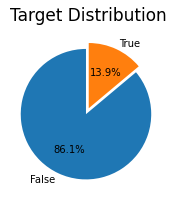

In [16]:
plt.figure(figsize = (3,3))
plt.title("Target Distribution", {'fontsize': 17,} )
plt.pie(xy_train["GLAUCOMA"].value_counts(), labels = [False,True], autopct='%.1f%%', startangle=90, counterclock=True, explode = (0.1,0))
plt.show()

# 건강검진 결과 녹내장 

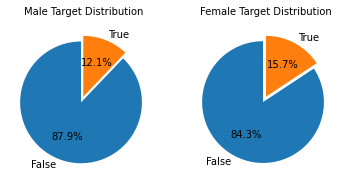

In [24]:
# 여성, 남성 집단의 녹내장 유병률

plt.figure(figsize = (6,6))

plt.subplot(1,2,1)
plt.title("Male Target Distribution", {'fontsize': 10,} )
plt.pie(xy_train[xy_train["SEX"]==1]["GLAUCOMA"].value_counts(), labels = [False,True], autopct='%.1f%%', startangle=90, counterclock=True, explode = (0.1,0))

plt.subplot(1,2,2)
plt.title("Female Target Distribution", {'fontsize': 10,} )
plt.pie(xy_train[xy_train["SEX"]==2]["GLAUCOMA"].value_counts(), labels = [False,True], autopct='%.1f%%', startangle=90, counterclock=True, explode = (0.1,0))
plt.show()

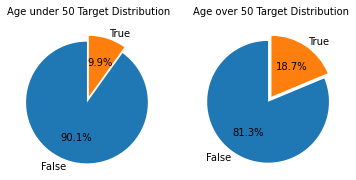

In [25]:
# 연령 50대 이상, 미만 집단

plt.figure(figsize = (6,6))

plt.subplot(1,2,1)
plt.title("Age under 50 Target Distribution", {'fontsize': 10,} )
plt.pie(xy_train[xy_train["AGE_G"]<15]["GLAUCOMA"].value_counts(), labels = [False,True], autopct='%.1f%%', startangle=90, counterclock=True, explode = (0.1,0))

plt.subplot(1,2,2)
plt.title("Age over 50 Target Distribution", {'fontsize': 10,} )
plt.pie(xy_train[xy_train["AGE_G"]>=15]["GLAUCOMA"].value_counts(), labels = [False,True], autopct='%.1f%%', startangle=90, counterclock=True, explode = (0.1,0))

plt.show()

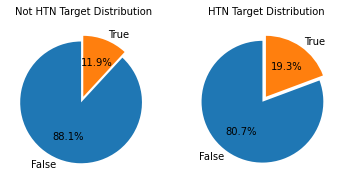

In [26]:
# 고혈압 유무 집단

plt.figure(figsize = (6,6))

plt.subplot(1,2,1)
plt.title("Not HTN Target Distribution", {'fontsize': 10,} )
plt.pie(xy_train[xy_train["HTN"]==0]["GLAUCOMA"].value_counts(), labels = [False,True], autopct='%.1f%%', startangle=90, counterclock=True, explode = (0.1,0))

plt.subplot(1,2,2)
plt.title("HTN Target Distribution", {'fontsize': 10,} )
plt.pie(xy_train[xy_train["HTN"]==1]["GLAUCOMA"].value_counts(), labels = [False,True], autopct='%.1f%%', startangle=90, counterclock=True, explode = (0.1,0))

plt.show()

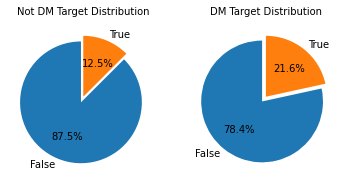

In [27]:
# 당뇨병 유무 집단

plt.figure(figsize = (6,6))

plt.subplot(1,2,1)
plt.title("Not DM Target Distribution", {'fontsize': 10,} )
plt.pie(xy_train[xy_train["DM"]==0]["GLAUCOMA"].value_counts(), labels = [False,True], autopct='%.1f%%', startangle=90, counterclock=True, explode = (0.1,0))

plt.subplot(1,2,2)
plt.title("DM Target Distribution", {'fontsize': 10,} )
plt.pie(xy_train[xy_train["DM"]==1]["GLAUCOMA"].value_counts(), labels = [False,True], autopct='%.1f%%', startangle=90, counterclock=True, explode = (0.1,0))

plt.show()

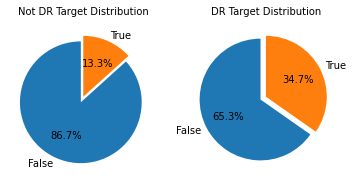

In [28]:
# 당뇨망막병증 유무 집단

plt.figure(figsize = (6,6))

plt.subplot(1,2,1)
plt.title("Not DR Target Distribution", {'fontsize': 10,} )
plt.pie(xy_train[xy_train["DR"]==0]["GLAUCOMA"].value_counts(), labels = [False,True], autopct='%.1f%%', startangle=90, counterclock=True, explode = (0.1,0))

plt.subplot(1,2,2)
plt.title("DR Target Distribution", {'fontsize': 10,} )
plt.pie(xy_train[xy_train["DR"]==1]["GLAUCOMA"].value_counts(), labels = [False,True], autopct='%.1f%%', startangle=90, counterclock=True, explode = (0.1,0))

plt.show()

In [ ]:
# sns.pairplot(x_train) # 바이너리 데이터가 많아서 딱히 뭐가 안보인다. 기각

In [30]:
from pandas.core.groupby.groupby import DataError
from operator import xor
# 완전 실명, 한쪽 실명 컬럼 추가
# 의문점
# 시력 컬럼에 이상치 9.9 로 이미 단서가 주어져있긴하다. 이걸 컬럼을 쪼개는게 의미가 있는가
# 모델에 따라 다를것은 확실해보인다.
# 트리 기반의 경우 어떤 차이를 보일지 확인해보면 좋을 것 같다.

def add_columns(data) :

  # 평균 시력 : 실명값은 0 으로 변경하여 평균
  # 실명 시력 0으로 조정
  left_sight = data['VA_LT']
  right_sight = data['VA_RT']
  left_sight = left_sight.replace({9.9 : 0})
  right_sight = right_sight.replace({9.9 : 0})
  mean_sight = (left_sight+right_sight)/2
  data["mean_sight"] = mean_sight
  data["VA_LT"] = left_sight
  data["VA_RT"] = right_sight

  left_blind = data['VA_LT'] == 0
  right_blind = data['VA_RT'] == 0
  Both_Blind = []
  One_Blind = []
  for l,r in zip(left_blind, right_blind) :
    Both_Blind.append(int(l and r))
    One_Blind.append(int(l ^ r))
  # 완전 실명
  data['Both_Blind'] = Both_Blind
  # 한쪽 실명
  data['One_Blind'] = One_Blind
  data = data.replace({True : 1, False : 0})

  # 좌우 시력차이(절대값)
  data["sight_difference"] = abs(data["VA_LT"] - data["VA_RT"])

  return data

In [31]:
x_train = add_columns(x_train)

In [32]:
# xy_train
xy_train = x_train.copy()
xy_train["GLAUCOMA"] = y_train

In [33]:
print(x_train["Both_Blind"].value_counts())
print(x_train["One_Blind"].value_counts(normalize = True))

0    799479
1       521
Name: Both_Blind, dtype: int64
0    0.993634
1    0.006366
Name: One_Blind, dtype: float64


In [52]:
# 폰트 지정
# 'serif' 'sans-serif' 'cursive' 'fantasy' 'monospace'
# 제목
font1 = {'family': 'serif',
         'color': 'black',
         'weight': 'bold',
         'size': 10
         }

font2 = {'family': 'fantasy',
         'color': 'red',
         'weight': 'normal',
         'size': 'xx-large'
         }
 
# 축
font3 = {'family': 'monospace',
         'color': 'black',
         'weight': 'normal',
         'size': 8
         }

In [35]:
xy_train["Both_Blind"].sum()

521

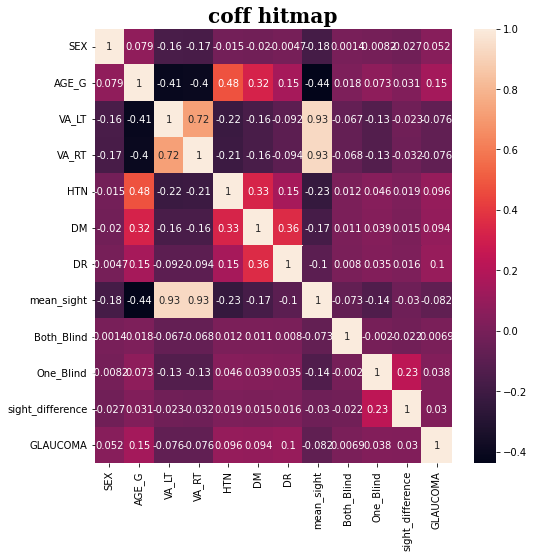

In [38]:
corr = xy_train.corr()  # 자동으로 수치형 데이터 간의 correlation coefficient를 계산해 줍니다.
plt.figure(figsize = (8,8))
plt.title("coff hitmap", fontdict = font1)
sns.heatmap(corr, annot=True)
plt.show()

# 나이 - 고혈압
# 나이 - 당뇨
# 나이 - 녹내장
# 녹내장 - 당뇨머시기


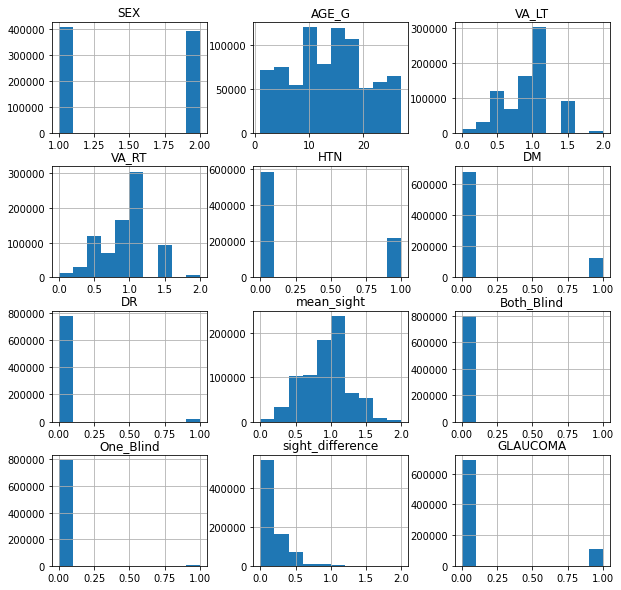

In [41]:
# 전체 히스토그램
xy_train.hist(figsize = (10,10))
plt.show()

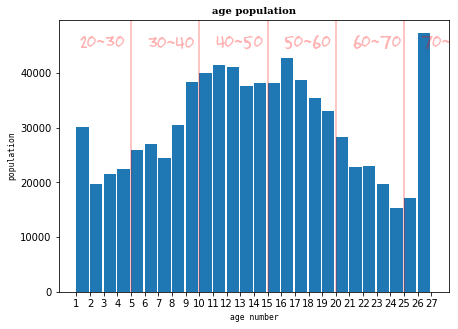

In [53]:
# 나이별 겸진 인구 수 hist

# 20대, 30대, 40대, 50대, 60대, 70대 이상
# 1~4, 5~9, 10~14, 15~19, 20~24, 25~27 

plt.figure(figsize = (7,5))
plt.title("age population", fontdict = font1)
temp = xy_train["AGE_G"]
plt.hist(temp, bins = 26, width = 0.9)
plt.xlabel('age number', fontdict=font3)
plt.ylabel('population', fontdict=font3)
plt.xticks(range(1,28))

plt.axvline(x = 5, color = 'r', alpha = 0.3)
plt.text(1.2, 45000, "20~30", fontdict = font2, alpha = 0.3)

plt.axvline(x = 10, color = 'r', alpha = 0.3)
plt.text(6.2, 45000, "30~40", fontdict = font2, alpha = 0.3)

plt.axvline(x = 15, color = 'r', alpha = 0.3)
plt.text(11.2, 45000, "40~50", fontdict = font2, alpha = 0.3)

plt.axvline(x = 20, color = 'r', alpha = 0.3)
plt.text(16.2, 45000, "50~60", fontdict = font2, alpha = 0.3)

plt.axvline(x = 25, color = 'r', alpha = 0.3)
plt.text(21.2, 45000, "60~70", fontdict = font2, alpha = 0.3)

plt.text(26.2, 45000, "70~", fontdict = font2, alpha = 0.3)

plt.show()

In [45]:
# 나이별 녹내장 추이

temp = xy_train[["AGE_G", "GLAUCOMA"]]
age_gla_sum = temp.groupby('AGE_G').sum()
age_gla_count = temp.groupby('AGE_G').count()
age_gla= age_gla_sum
age_gla["count"] = age_gla_count["GLAUCOMA"]
age_gla["ratio"] = age_gla["GLAUCOMA"] / age_gla["count"] * 100

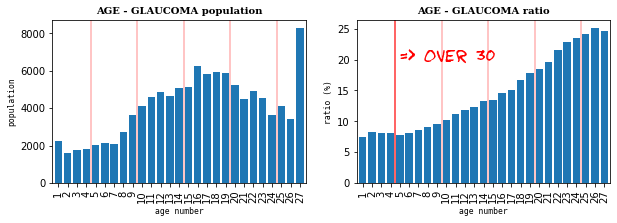

In [54]:
plt.figure(figsize = (10,3))

plt.subplot(1,2,1)
plt.title("AGE - GLAUCOMA population", fontdict = font1)
age_gla["GLAUCOMA"].plot(kind = 'bar', width = 0.8)
plt.xlabel('age number', fontdict=font3)
plt.ylabel('population', fontdict=font3)

plt.axvline(x = 3.5, color = 'r', alpha = 0.3)
plt.axvline(x = 8.5, color = 'r', alpha = 0.3)
plt.axvline(x = 13.5, color = 'r', alpha = 0.3)
plt.axvline(x = 18.5, color = 'r', alpha = 0.3)
plt.axvline(x = 23.5, color = 'r', alpha = 0.3)


plt.subplot(1,2,2)
plt.title("AGE - GLAUCOMA ratio", fontdict = font1)
age_gla["ratio"].plot(kind = 'bar', width = 0.8)
plt.text(4, 20, "=> over 30", fontdict = font2)
plt.xlabel('age number', fontdict=font3)
plt.ylabel('ratio (%)', fontdict=font3)

plt.axvline(x = 3.5, color = 'r', alpha = 0.8)
plt.axvline(x = 8.5, color = 'r', alpha = 0.3)
plt.axvline(x = 13.5, color = 'r', alpha = 0.3)
plt.axvline(x = 18.5, color = 'r', alpha = 0.3)
plt.axvline(x = 23.5, color = 'r', alpha = 0.3)

plt.show()

In [66]:
def age_columns_plot(feature, title1, title2) :
  temp = xy_train[["AGE_G", feature]]
  age_feat_sum = temp.groupby('AGE_G').sum()
  age_feat_count = temp.groupby('AGE_G').count()
  age_feat = age_feat_sum
  age_feat["count"] = age_feat_count[feature]
  age_feat["ratio"] = age_feat[feature] / age_feat["count"] * 100

  plt.figure(figsize = (10,3))

  plt.subplot(1,2,1)
  plt.title(title1, fontdict = font1)
  age_feat[feature].plot(kind = 'bar', width = 0.8)
  plt.xlabel('age number', fontdict=font3)
  plt.ylabel('population', fontdict=font3)

  plt.subplot(1,2,2)
  plt.title(title2, fontdict = font1)
  age_feat["ratio"].plot(kind = 'bar', width = 0.8)
  plt.xlabel('age number', fontdict=font3)
  plt.ylabel('ratio (%)', fontdict=font3)
  plt.show()

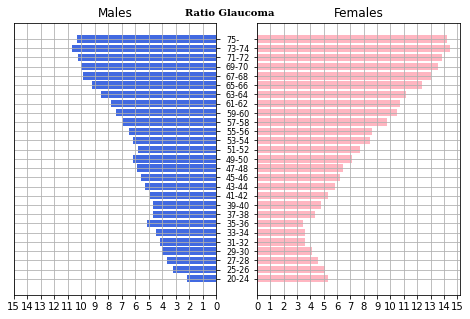

In [63]:
#define x and y limits

temp = xy_train[['SEX','AGE_G','GLAUCOMA']]
gtemp = temp.groupby(['SEX', 'AGE_G']).sum()
gtemp2 = gtemp.iloc[27:,:]

gtemp = gtemp.iloc[0:27,:]
age = ['20-24','25-26','27-28','29-30','31-32','33-34','35-36','37-38','39-40','41-42','43-44','45-46','47-48','49-50','51-52','53-54','55-56','57-58','59-60','61-62','63-64','65-66','67-68','69-70','71-72','73-74','75-']

y = range(0, len(gtemp2))
x_male = gtemp['GLAUCOMA'].reset_index()['GLAUCOMA']
x_female = gtemp2['GLAUCOMA'].reset_index()['GLAUCOMA']

x_male = x_male/age_gla_sum['count'].reset_index(drop = True) * 100
x_female = x_female/age_gla_sum['count'].reset_index(drop = True) * 100

#define plot parameters
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(8, 5))

#specify background color and plot title
#fig.patch.set_facecolor('xkcd:light grey')
plt.figtext(.5,.9,"Ratio Glaucoma", fontdict = font1, ha='center')
    
#define male and female bars
axes[0].barh(y, x_male, align='center', color='royalblue')
axes[0].set(title='Males')
axes[1].barh(y, x_female, align='center', color='lightpink')
axes[1].set(title='Females')

#adjust grid parameters and specify labels for y-axis
axes[0].grid()
axes[1].grid()
axes[1].set(xticks = range(0,16))

axes[0].invert_xaxis()
axes[0].yaxis.tick_right()
axes[0].set(yticks=y, xticks = range(0,16))
axes[0].tick_params(axis='y', pad=6)
axes[0].yaxis.label.set_size(50)
axes[0].set_yticklabels(labels=age, Fontsize= 8)

#display plot
plt.show()

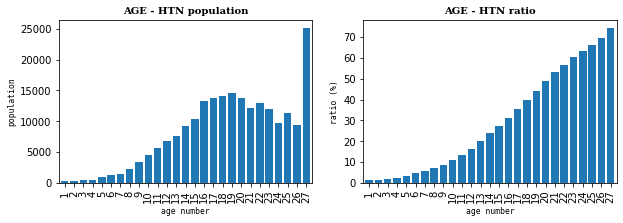

In [67]:
# 나이별 고혈압 추이
age_columns_plot("HTN","AGE - HTN population","AGE - HTN ratio")

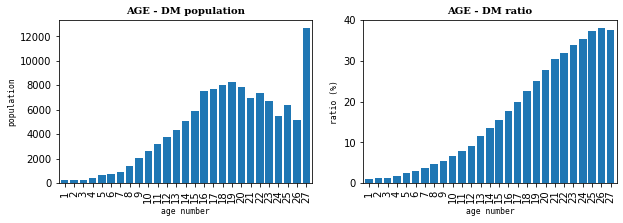

In [68]:
# 나이별 당뇨 추이
age_columns_plot("DM","AGE - DM population","AGE - DM ratio")

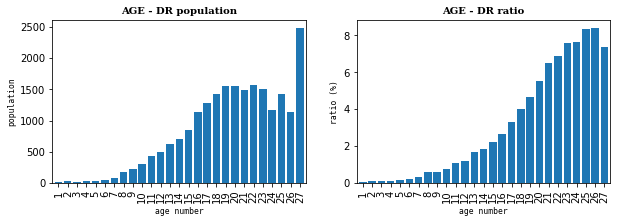

In [69]:
# 나이별 당뇨망막병증 추이
age_columns_plot("DR","AGE - DR population","AGE - DR ratio")

In [70]:
# 녹내장 실명률
glau = (xy_train["GLAUCOMA"]==1).sum()
glau_blind = xy_train.query("((GLAUCOMA == 1) and (One_Blind == 1)) or ((GLAUCOMA == 1) and (Both_Blind == 1))")["SEX"].count()

dr = (xy_train["DR"]==1).sum()
dr_blind = xy_train.query("((DR == 1) and (One_Blind == 1)) or ((DR == 1) and (Both_Blind == 1))")["SEX"].count()

In [71]:
c = xy_train['Both_Blind'].sum() + xy_train['One_Blind'].sum()

In [72]:
print(f"녹내장 진단 수 : {glau}\n녹내장+실명 : {glau_blind}\n녹내장 실명률 : {glau_blind/glau*100}\n")
print(f"당뇨망막병증 진단 수 : {dr}\n당뇨망막병증+실명 : {dr_blind}\n당뇨망막병증 실명률 : {dr_blind/dr*100}\n")
print(f"측정 인구 : 800000 \n실명 : {c}\n실명률 : {c/800000*100}")

녹내장 진단 수 : 111164
녹내장+실명 : 1663
녹내장 실명률 : 1.4959879097549567

당뇨망막병증 진단 수 : 21869
당뇨망막병증+실명 : 542
당뇨망막병증 실명률 : 2.4783940738031003

측정 인구 : 800000 
실명 : 5614
실명률 : 0.70175


In [73]:
# 녹내장 평균 시력
gla_mean_sight = xy_train.query("GLAUCOMA == 1")['mean_sight'].mean()
mean_sight = xy_train['mean_sight'].mean()
print(f"녹내장 평균 시력 : {gla_mean_sight}")
print(f"전체 평균 시력 : {mean_sight}")

녹내장 평균 시력 : 0.8643369256234035
전체 평균 시력 : 0.9307808125


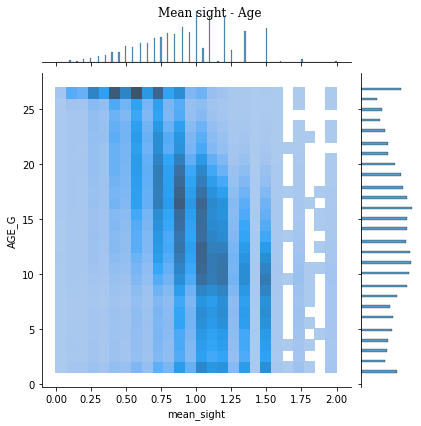

In [74]:
# 평균시력, 나이
rel = sns.jointplot(data=xy_train, x="mean_sight", y="AGE_G", kind="hist", bins = 26)
rel.fig.suptitle("Mean sight - Age", fontdict = font1)
plt.show()

In [ ]:
# 양쪽 시력, 나이
# 기각

import plotly.express as px
fig = px.scatter(xy_train, x="VA_LT", y="VA_RT", color="AGE_G",
                 size='SEX', hover_data=['HTN','GLAUCOMA'])#, width=20, height=20)
fig.update_layout(
    title={
        'text': "sight - age",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

## Train set MODELING

In [78]:
x_train_noval, x_val, y_train_noval, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

### Base Model

In [79]:
y_base = [0]*len(x_train)

In [80]:
from sklearn.metrics import accuracy_score

s = accuracy_score(y_train, y_base)

print(f"Base model 정확도 : {s}")

Base model 정확도 : 0.861045


In [81]:
from sklearn.metrics import f1_score

s = f1_score(y_train, y_base)

print(f"Base model f1 : {s}")

Base model f1 : 0.0


### Logistic

In [82]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score


logistic = LogisticRegression(class_weight='balanced')
logistic.fit(x_train_noval, y_train_noval)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(class_weight='balanced')

In [ ]:
scores = cross_val_score(logistic, x_train, y_train, cv=5, scoring='f1', verbose = 3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.299) total time=   1.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END ................................ score: (test=0.296) total time=   0.9s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV] END ................................ score: (test=0.297) total time=   1.8s
[CV] END ................................ score: (test=0.297) total time=   1.7s
[CV] END ................................ score: (test=0.296) total time=   1.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.2s finished


In [ ]:
scores

array([0.29945423, 0.29625439, 0.29749737, 0.29667117, 0.29623875])

In [ ]:
y_val_pred_logi = logistic.predict(x_val)

In [ ]:
print('logistic val f1:', f1_score(y_val, y_val_pred_logi).round(5))
print("logistic cv f1: ", (scores.mean()).round(5))
print("logistic val accuracy: ", accuracy_score(y_val, y_val_pred_logi))

logistic val f1: 0.294
logistic cv f1:  0.29722
logistic val accuracy:  0.6196


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



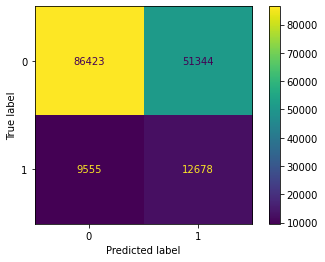

In [83]:
plot_confusion_matrix(logistic, x_val, y_val)  

In [ ]:
pd.Series(logistic.coef_[0], logistic.feature_names_in_).sort_values(ascending=False)

DR                  0.791055
One_Blind           0.444508
sight_difference    0.312431
SEX                 0.273351
DM                  0.185785
Both_Blind          0.151063
HTN                 0.120559
AGE_G               0.049370
VA_RT              -0.007592
mean_sight         -0.012039
VA_LT              -0.016486
dtype: float64

In [ ]:
y_pred_proba = logistic.predict_proba(x_val)[:,1]
f1 = 0
best_threshold = 0
for threshold in np.arange(0.5,0.6,0.001) :
  y_pred = y_pred_proba > threshold
  nf1 = f1_score(y_val, y_pred)
  if nf1 > f1 :
    f1 = nf1
    best_threshold = threshold
print(best_threshold)

0.528


False    109036
True      50964
dtype: int64

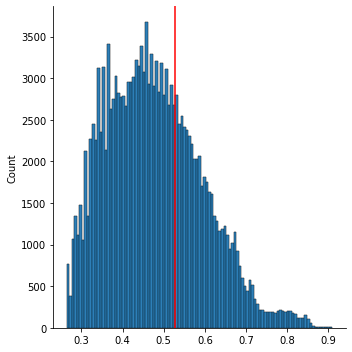

In [86]:
y_pred_proba_logi = logistic.predict_proba(x_val)[:,1]
sns.displot(y_pred_proba_logi)

threshold = 0.528
y_pred = y_pred_proba_logi > threshold

ax = sns.histplot(y_pred_proba_logi)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [87]:
import random

temp = []
for i in range(len(y_pred_proba_logi)) :
  temp.append(random.uniform(-1, 1))
proba_df = pd.DataFrame({'y_val':y_val, 'y_pred_proba': y_pred_proba_logi, 'ytemp': temp,})

In [88]:
proba_df = proba_df.sort_values('y_pred_proba')

In [ ]:
fig = px.scatter(proba_df, x="y_pred_proba", y="ytemp", color="y_val",
                  width=200, height=300)
# fig.update_layout(
#     title={
#         'text': "sight - age",
#         'y':0.97,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'})
fig.show()

In [90]:
threshold = 0.528
y_pred = y_pred_proba_logi > threshold

In [91]:
print('logistic val f1:', f1_score(y_val, y_pred).round(5))
print("logistic val accuracy: ", accuracy_score(y_val, y_pred))

logistic val f1: 0.29542
logistic val accuracy:  0.67766875


In [92]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[97615, 40152],
       [11421, 10812]])

### column drop

In [93]:
x_train_noval_drop = x_train_noval.drop(columns = ['VA_LT','mean_sight','VA_RT'])
x_val_drop = x_val.drop(columns = ['VA_LT','mean_sight','VA_RT'])
x_train_drop = x_train.drop(columns = ['VA_LT','mean_sight','VA_RT'])

In [94]:
logistic = LogisticRegression(class_weight='balanced')
logistic.fit(x_train_noval_drop, y_train_noval)
y_val_pred = logistic.predict(x_val_drop)
scores = cross_val_score(logistic, x_train_drop, y_train, cv=5, scoring='f1', verbose = 3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.300) total time=   8.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s


[CV] END ................................ score: (test=0.296) total time=   9.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.5s remaining:    0.0s
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END ................................ score: (test=0.297) total time=  11.4s
[CV] END ................................ score: (test=0.297) total time=   7.6s
[CV] END ................................ score: (test=0.296) total time=  14.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.6s finished


In [ ]:
print('logistic val f1:', f1_score(y_val, y_val_pred).round(5))
print("logistic cv f1: ", (scores.mean()).round(5))
print("logistic val accuracy: ", accuracy_score(y_val, y_val_pred))

# 큰 차이 없고 cv 점수 오히려 하락

logistic val f1: 0.29417
logistic cv f1:  0.29717
logistic val accuracy:  0.6204375


### K-Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler


knn_pipe = make_pipeline( MinMaxScaler(), KNeighborsClassifier(),)


In [ ]:
knn_pipe.fit(x_train_noval, y_train_noval)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
scores = cross_val_score(knn_pipe, x_train, y_train, cv=5, scoring='f1', verbose = 3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.089) total time= 1.2min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] END ................................ score: (test=0.088) total time= 1.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


[CV] END ................................ score: (test=0.087) total time= 1.1min
[CV] END ................................ score: (test=0.084) total time= 1.1min
[CV] END ................................ score: (test=0.088) total time= 1.1min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.6min finished


In [ ]:
scores2 = cross_val_score(knn_pipe, x_train, y_train, cv=5, scoring='accuracy', verbose = 3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.843) total time= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] END ................................ score: (test=0.843) total time= 1.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


[CV] END ................................ score: (test=0.845) total time= 1.1min
[CV] END ................................ score: (test=0.843) total time= 1.1min
[CV] END ................................ score: (test=0.843) total time= 1.1min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.6min finished


In [ ]:
scores

array([0.08935031, 0.08783318, 0.08677428, 0.08426044, 0.08806993])

In [ ]:
scores2

array([0.8426625 , 0.84279375, 0.84476875, 0.84309375, 0.84286875])

In [ ]:
y_val_pred = knn_pipe.predict(x_val)

In [ ]:
y_pred_proba_knn = knn_pipe.predict_proba(x_val)

In [ ]:
print('knn val f1:', f1_score(y_val, y_val_pred).round(5))
print("knn cv f1: ", (scores.mean()).round(5))
print("knn cv accuracy: ", (scores2.mean()).round(5))
print("knn val accuracy: ", accuracy_score(y_val, y_val_pred))

knn val f1: 0.08634
knn cv f1:  0.08726
knn cv accuracy:  0.84324
knn val accuracy:  0.84285625


/Users/youlimoh/opt/anaconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



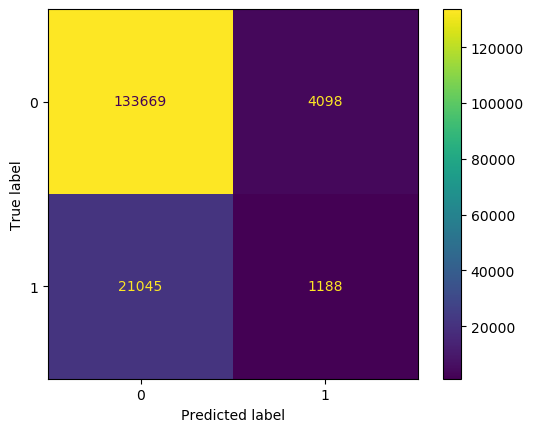

In [ ]:
plot_confusion_matrix(knn_pipe, x_val, y_val)

### xgboost

In [97]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
xgb = XGBClassifier(
    n_jobs = -1, eval_metric = 'error', objective = 'binary:logistic', booster = 'gbtree',
        learning_rate = 0.02,
        max_depth = 4,
        max_leaves = 5,
        scale_pos_weight = 6.15,
        n_estimators = 200,)

In [ ]:
scores = cross_val_score(xgb, x_train, y_train, cv=5, scoring='f1', verbose = 3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.301) total time=  15.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s remaining:    0.0s


[CV] END ................................ score: (test=0.297) total time=  16.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.0s remaining:    0.0s


[CV] END ................................ score: (test=0.298) total time=  16.7s
[CV] END ................................ score: (test=0.298) total time=  16.6s
[CV] END ................................ score: (test=0.297) total time=  16.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished


In [ ]:
scores2 = cross_val_score(xgb, x_train, y_train, cv=5, scoring='accuracy', verbose = 3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.640) total time=  17.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.2s remaining:    0.0s


[CV] END ................................ score: (test=0.641) total time=  16.9s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.0s remaining:    0.0s


[CV] END ................................ score: (test=0.636) total time=  17.1s
[CV] END ................................ score: (test=0.636) total time=  17.2s
[CV] END ................................ score: (test=0.640) total time=  17.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished


In [ ]:
scores

array([0.30079918, 0.29731516, 0.29824434, 0.29804829, 0.29739188])

In [ ]:
scores2

array([0.6402    , 0.6411125 , 0.6362625 , 0.63606875, 0.63985625])

In [ ]:
xgb.fit(x_train_noval,y_train_noval)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=5, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
y_val_pred = xgb.predict(x_val)

In [ ]:
y_pred_proba_xgb = xgb.predict_proba(x_val)

In [ ]:
print('xgb val f1:', f1_score(y_val, y_val_pred).round(5))
print("xgb cv f1: ", (scores.mean()).round(5))
print("xgb cv accuracy: ", (scores2.mean()).round(5))
print("xgb val accuracy: ", accuracy_score(y_val, y_val_pred))

xgb val f1: 0.29501
xgb cv f1:  0.29836
xgb cv accuracy:  0.6387
xgb val accuracy:  0.63795


In [ ]:
train_pred = xgb.predict(x_train)

In [ ]:
accuracy_score(y_train, train_pred)

0.6386775

In [ ]:
f1_score(y_train, train_pred)

0.29884879033236145

In [ ]:
from sklearn.metrics import plot_confusion_matrix

/Users/youlimoh/opt/anaconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



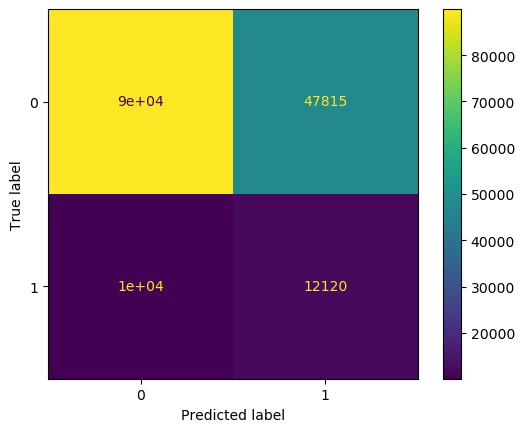

In [ ]:
plot_confusion_matrix(xgb, x_val, y_val)  

### roc curve, roc-auc score

In [ ]:
from sklearn.metrics import roc_curve

# roc_curve(타겟값, prob of 1)

# y_pred_proba_logi
# y_pred_proba_knn
# y_pred_proba_xgb


fpr_logi, tpr_logi, thresholds_logi = roc_curve(y_val, y_pred_proba_logi)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, y_pred_proba_knn[:,1])
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_val, y_pred_proba_xgb[:,1])

# roc_logi = pd.DataFrame({
#     'FPR(Fall-out)': fpr_logi, 
#     'TPR(Recall)': tpr_logi, 
#     'Threshold': thresholds_logi
# })

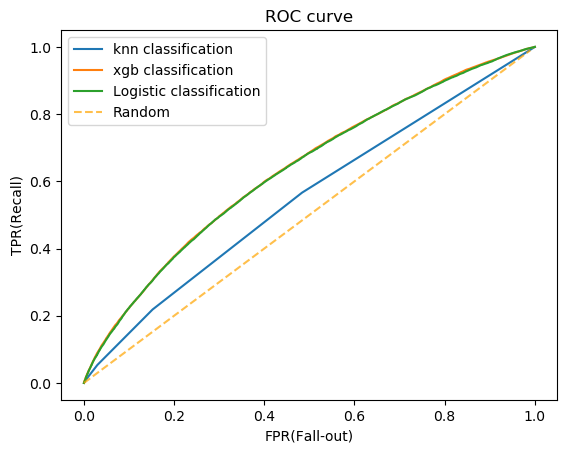

In [ ]:
plt.plot(fpr_knn, tpr_knn, label='knn classification')
plt.plot(fpr_xgb, tpr_xgb, label='xgb classification')
plt.plot(fpr_logi, tpr_logi, label='Logistic classification')

x_base = np.arange(0, 1.0, 0.01)
y_base = np.arange(0, 1.0, 0.01)
plt.plot(x_base, y_base, linestyle='--', color = 'orange', alpha=0.7, label='Random')
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.legend();

In [ ]:
fpr_logi, tpr_logi, thresholds_logi = roc_curve(y_val, y_pred_proba_logi)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, y_pred_proba_knn[:,1])
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_val, y_pred_proba_xgb[:,1])

In [ ]:
from sklearn.metrics import roc_auc_score

logi_auc = roc_auc_score(y_val, y_pred_proba_logi)
print(f"Logistic Classification 의 auc score : {logi_auc.round(3)}")
knn_auc = roc_auc_score(y_val, y_pred_proba_knn[:,1])
print(f"KNN Classification 의 auc score : {knn_auc.round(3)}")
xgb_auc = roc_auc_score(y_val, y_pred_proba_xgb[:,1])
print(f"XGB Classification 의 auc score : {xgb_auc.round(3)}")


Logistic Classification 의 auc score : 0.635
KNN Classification 의 auc score : 0.552
XGB Classification 의 auc score : 0.636


문제 정의와 오류 선택 :    
이번 머신의 목적은 아직 녹내장 진단을 받지 않은 군에서 위험군을 추려내는 것이다. 즉 이미 녹내장 진단을 받은 사람들에 대한 예측이 정확할수록 좋고, 아직 진단을 받지 않은 사람들 가운데 위험군을 1로 분류 하는게 목적과 부합한다. 즉 2종 오류보다 1종 오류에 덜 민감한 모델을 구성하도록 한다.

모델 선정 :  
XGB 와 로지스틱의 f1 성능이 유사하나 XGB 는 하이퍼파라미터 조정을 통한 성능 향상의 여지가 더 크다고 판단하여 XGB 를 최종 머신으로 선정한다.

## XGB 하이퍼파라미터 튜닝 with Bayesian Search

In [ ]:
from hyperopt import hp

params = {
    "xgbclassifier__learning_rate": hp.uniform("learning_rate", 0.02, 1.0),
    "xgbclassifier__max_depth": hp.quniform("max_depth", 3, 5, 1),
    "xgbclassifier__max_leaves": hp.quniform("max_leaves", 1, 5, 1),
    "xgbclassifier__scale_pos_weight": hp.uniform("scale_pos_weight", 4, 7),
    "xgbclassifier__colsample_bytree": hp.uniform("colsample_bytree", 0.1, 0.6),
    "xgbclassifier__min_child_weight": hp.uniform("min_child_weight", 0.01, 5),
}

In [ ]:
from hyperopt import fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
import numpy as np

def get_pipe(params):
    params["xgbclassifier__max_depth"] = int(
        params["xgbclassifier__max_depth"]
    )  # max_depth는 정수형으로 변환해 줍니다.
    
    params["xgbclassifier__max_leaves"] = int(
        params["xgbclassifier__max_leaves"]
    )
    
    pipe = make_pipeline(
        XGBClassifier(
            objective="binary:logistic",
            eval_metric="error",
            n_estimators=1900,
            random_state=55,
            n_jobs=-1,
            learning_rate=0.1,
            #predictor = 'auto',
            use_label_encoder=False,
            booster = 'gbtree',
        ),
    )
    
    pipe = pipe.set_params(**params)
    return pipe


def fit_and_eval(params):
    pipe = get_pipe(params)  # 주어진 params로 파이프라인을 만들어 가져옵니다.
    # skfold = StratifiedKFold(n_splits = 3)
    score = cross_val_score(pipe, x_train, y_train, cv=3, scoring="f1", verbose = 3)
    avg_cv_score = np.mean(score)
    # f1는 클수록 좋은 metric이므로, hyperopt.fmin이 f1을 최대화하도록 하기 위해 -부호를 붙여 반환합니다.
    print(score)
    return {"loss": -avg_cv_score, "status": STATUS_OK}


trials = (
    Trials()
)  # Trials() 객체를 fmin에 함께 넣어 실행하면, 실행되는 매 fit의 학습 정보 및 학습 결과가 해당 객체에 모두 저장됩니다.

best_params = fmin(
    fn=fit_and_eval, trials=trials, space=params, algo=tpe.suggest, max_evals=10,
)  # max_evals 횟수만큼 하이퍼파라미터 조합을 탐색합니다.

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] END ................................ score: (test=0.292) total time= 1.5min
  0%|          | 0/10 [01:29<?, ?trial/s, best loss=?]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s



[CV] END ................................ score: (test=0.295) total time= 1.5min
  0%|          | 0/10 [03:00<?, ?trial/s, best loss=?]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min remaining:    0.0s



[CV] END ................................ score: (test=0.289) total time= 1.5min
[0.29179829 0.29538486 0.28942629]                    
 10%|█         | 1/10 [04:33<40:57, 273.02s/trial, best loss: -0.2922031471387155]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.6min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] END ................................ score: (test=0.291) total time= 1.3min  
 10%|█         | 1/10 [05:53<40:57, 273.02s/trial, best loss: -0.2922031471387155]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s



[CV] END ................................ score: (test=0.295) total time= 1.5min  
 10%|█         | 1/10 [07:21<40:57, 273.02s/trial, best loss: -0.2922031471387155]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min remaining:    0.0s



[CV] END ................................ score: (test=0.290) total time= 1.5min  
[0.29085057 0.29526695 0.29033865]                                                
 20%|██        | 2/10 [08:48<35:02, 262.77s/trial, best loss: -0.2922031471387155]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.3min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] END ................................ score: (test=0.294) total time= 1.2min  
 20%|██        | 2/10 [10:02<35:02, 262.77s/trial, best loss: -0.2922031471387155]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s



[CV] END ................................ score: (test=0.295) total time= 1.3min  
 20%|██        | 2/10 [11:23<35:02, 262.77s/trial, best loss: -0.2922031471387155]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s



[CV] END ................................ score: (test=0.291) total time= 1.3min  
[0.29357072 0.29497579 0.29112339]                                                
 30%|███       | 3/10 [12:38<28:54, 247.76s/trial, best loss: -0.29322330075779174]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.8min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] END ................................ score: (test=0.288) total time= 1.3min   
 30%|███       | 3/10 [13:54<28:54, 247.76s/trial, best loss: -0.29322330075779174]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s



[CV] END ................................ score: (test=0.294) total time= 1.2min   
 30%|███       | 3/10 [15:09<28:54, 247.76s/trial, best loss: -0.29322330075779174]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s



[CV] END ................................ score: (test=0.288) total time= 1.2min   
[0.28788592 0.29355412 0.28834033]                                                 
 40%|████      | 4/10 [16:22<23:49, 238.24s/trial, best loss: -0.29322330075779174]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.7min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] END ................................ score: (test=0.288) total time= 1.7min   
 40%|████      | 4/10 [18:03<23:49, 238.24s/trial, best loss: -0.29322330075779174]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s



[CV] END ................................ score: (test=0.292) total time= 1.7min   
 40%|████      | 4/10 [19:43<23:49, 238.24s/trial, best loss: -0.29322330075779174]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min remaining:    0.0s



[CV] END ................................ score: (test=0.288) total time= 1.7min   
[0.28835708 0.2916921  0.2884699 ]                                                 
 50%|█████     | 5/10 [21:24<21:46, 261.33s/trial, best loss: -0.29322330075779174]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.0min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] END ................................ score: (test=0.297) total time=  53.4s   
 50%|█████     | 5/10 [22:17<21:46, 261.33s/trial, best loss: -0.29322330075779174]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.4s remaining:    0.0s



[CV] END ................................ score: (test=0.300) total time=  53.4s   
 50%|█████     | 5/10 [23:11<21:46, 261.33s/trial, best loss: -0.29322330075779174]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s



[CV] END ................................ score: (test=0.296) total time=  53.4s   
[0.29726264 0.29994785 0.29555942]                                                 
 60%|██████    | 6/10 [24:04<15:07, 226.94s/trial, best loss: -0.2975899681749506] 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] END ................................ score: (test=0.276) total time= 1.1min  
 60%|██████    | 6/10 [25:10<15:07, 226.94s/trial, best loss: -0.2975899681749506]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s



[CV] END ................................ score: (test=0.279) total time= 1.1min  
 60%|██████    | 6/10 [26:14<15:07, 226.94s/trial, best loss: -0.2975899681749506]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s



[CV] END ................................ score: (test=0.276) total time= 1.1min  
[0.27605337 0.27885427 0.27610574]                                                
 70%|███████   | 7/10 [27:18<10:48, 216.03s/trial, best loss: -0.2975899681749506]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.2min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] END ................................ score: (test=0.285) total time= 1.6min  
 70%|███████   | 7/10 [28:52<10:48, 216.03s/trial, best loss: -0.2975899681749506]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s



[CV] END ................................ score: (test=0.289) total time= 1.6min  
 70%|███████   | 7/10 [30:27<10:48, 216.03s/trial, best loss: -0.2975899681749506]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s



[CV] END ................................ score: (test=0.285) total time= 1.6min  
[0.2845411  0.28886815 0.28466149]                                                
 80%|████████  | 8/10 [32:03<07:55, 237.95s/trial, best loss: -0.2975899681749506]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.7min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] END ................................ score: (test=0.284) total time=  53.4s  
 80%|████████  | 8/10 [32:56<07:55, 237.95s/trial, best loss: -0.2975899681749506]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.4s remaining:    0.0s



[CV] END ................................ score: (test=0.288) total time=  53.1s  
 80%|████████  | 8/10 [33:49<07:55, 237.95s/trial, best loss: -0.2975899681749506]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s



[CV] END ................................ score: (test=0.284) total time=  53.3s  
[0.28439591 0.28835663 0.28372728]                                                
 90%|█████████ | 9/10 [34:42<03:33, 213.50s/trial, best loss: -0.2975899681749506]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] END ................................ score: (test=0.298) total time= 1.1min  
 90%|█████████ | 9/10 [35:46<03:33, 213.50s/trial, best loss: -0.2975899681749506]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s



[CV] END ................................ score: (test=0.300) total time= 1.1min  
 90%|█████████ | 9/10 [36:50<03:33, 213.50s/trial, best loss: -0.2975899681749506]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s



[CV] END ................................ score: (test=0.295) total time= 1.1min  
[0.29754984 0.3        0.29489542]                                                
100%|██████████| 10/10 [37:54<00:00, 227.45s/trial, best loss: -0.2975899681749506]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.2min finished



In [ ]:
print("최적 하이퍼파라미터: ", trials.best_trial["misc"]["vals"])
print("최적 f1: ", -trials.best_trial["result"]["loss"])

최적 하이퍼파라미터:  {'colsample_bytree': [0.19837758060969848], 'learning_rate': [0.26895815728093964], 'max_depth': [3.0], 'max_leaves': [1.0], 'min_child_weight': [1.5008722487018042], 'scale_pos_weight': [6.274271972140673]}
최적 f1:  0.2975899681749506


In [ ]:
xgb_bas = XGBClassifier( booster='gbtree',
              eval_metric='error',
              learning_rate=0.27,
              max_depth=3, max_leaves = 1,
              colsample_bytree = 0.2,
              min_child_weight=1.5,
              n_estimators=1900, n_jobs=-1,
              scale_pos_weight = 6.27,
              predictor='auto', random_state=55,
              )

xgb_bas.fit(x_train, y_train)


In [ ]:
x_t = add_columns(x_test)
y_test_pred = xgb_bas.predict(x_t)
y_test_predproba = xgb_bas.predict_proba(x_t)

print('xgb test f1:', f1_score(y_test, y_test_pred).round(5))
print("xgb test accuracy: ", accuracy_score(y_test, y_test_pred))
auc = roc_auc_score(y_test, y_test_predproba[:,1])
print(f"Logistic Classification 의 auc score : {auc.round(5)}")

xgb test f1: 0.29681
xgb test accuracy:  0.62625
Logistic Classification 의 auc score : 0.6406


/Users/youlimoh/opt/anaconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


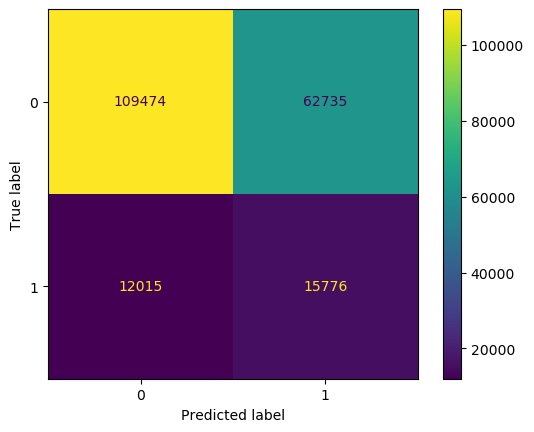

In [ ]:
plot_confusion_matrix(xgb_bas, x_t, y_test)  

In [ ]:
feature_important = xgb_bas.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

df = pd.DataFrame(data = values, index = keys, columns = ["score"]).sort_values(by = "score")
df.nlargest(40, columns = "score").plot(kind = 'barh', figsize = (10,5))

# 텍스트로 중요도값 적어주기

(<Figure size 1500x950 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f93c386b4c0>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f93d621d8b0>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f93c3898d00>}})

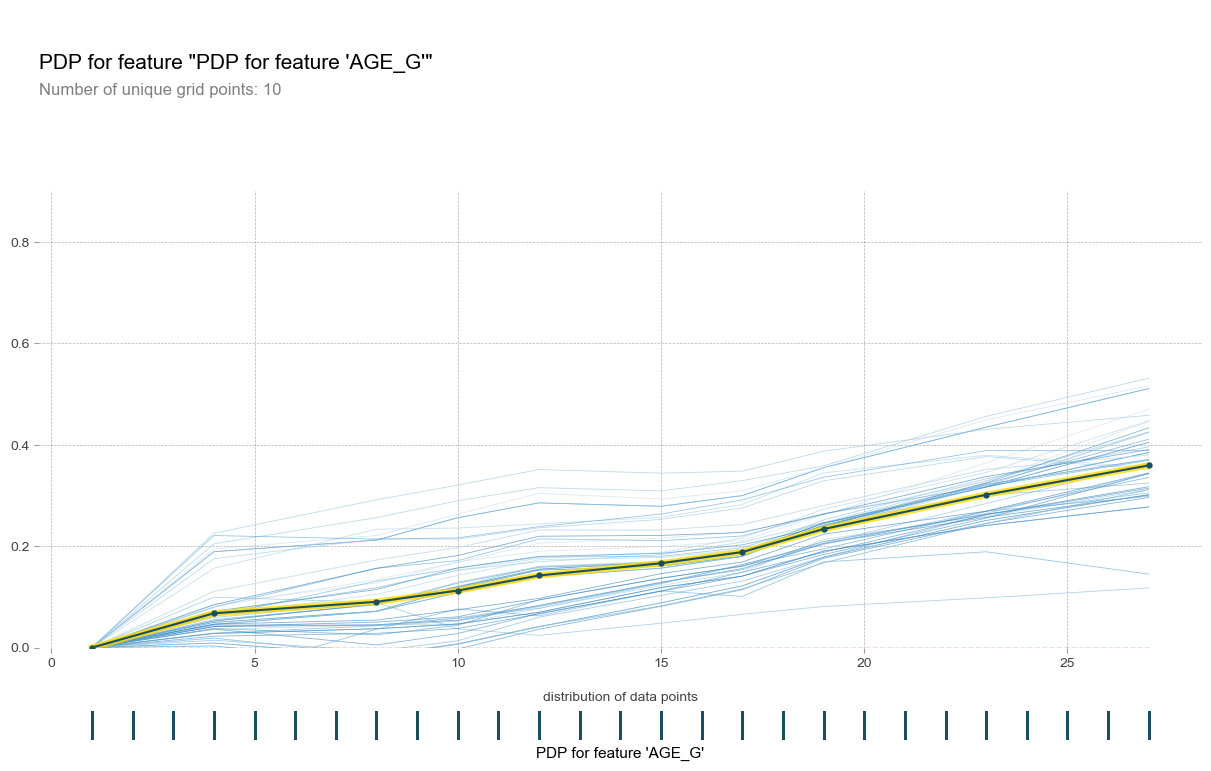

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

target_feature = 'AGE_G'

isolated = pdp_isolate(
    model = xgb_bas,
    dataset = x_val,
    model_features=x_val.columns,
    feature = target_feature,
    grid_type="percentile",
)

pdp_plot(isolated, feature_name = "PDP for feature 'AGE_G'", frac_to_plot = 50, plot_lines = True, plot_pts_dist=True)

(<Figure size 1500x950 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f9383689e80>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f93836cad90>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f93f4b93220>}})

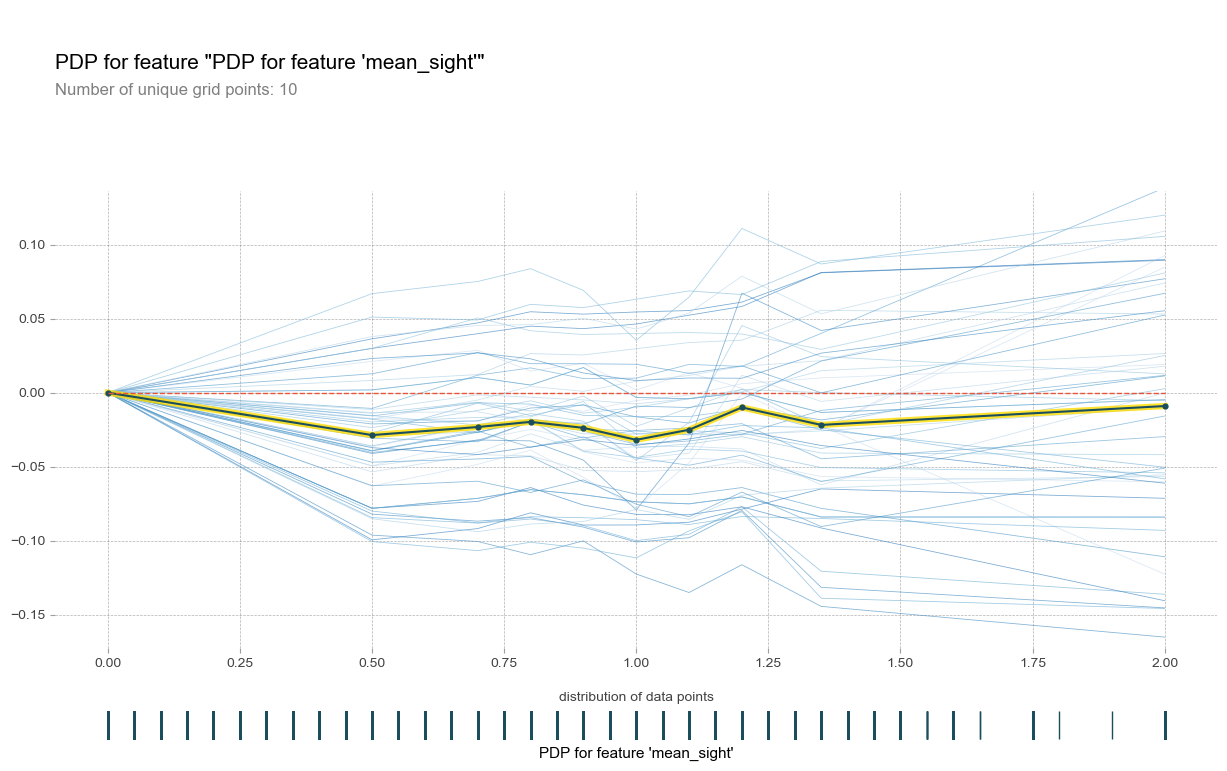

In [ ]:
target_feature = 'mean_sight'

isolated = pdp_isolate(
    model = xgb_bas,
    dataset = x_val,
    model_features=x_val.columns,
    feature = target_feature,
    grid_type="percentile",
)

pdp_plot(isolated, feature_name = "PDP for feature 'mean_sight'",frac_to_plot = 50, plot_lines = True, plot_pts_dist=True)